# Time Series Anomaly Detection using DeepAR

This notebook demonstrates an approach to **time series anomaly detection** with the use of [DeepAR](https://arxiv.org/abs/1704.04110), a probabilistic time series forecasting model developed by Amazon. The main idea is, at each time stamp, to **view the forecast distribution as characterizing the likelihood of different values under normal circumstances** and **flag any actual value as anomalous if its likelihood is too low**.

In this demo, we consider the time series of [NYC taxi passenger volume](https://github.com/numenta/NAB/blob/master/data/realKnownCause/nyc_taxi.csv) from the [Numenta Anomaly Benchmark repository](https://github.com/numenta/NAB). The time series comes with 5 labeled anomalies of known cases -- NYC marathon, Thanksgiving, Christmas, New Year's Day, and [a snow storm](https://en.wikipedia.org/wiki/January_2015_North_American_blizzard) -- but these labels are **NOT** used in model training, only for evaluation of final results.

Shown in the plot below are the time series, labeled anomalies (blue) and detected anomalies associated to a specific set of hyperparameter values. The result has the desired properties of capturing most of the labeled anomalies (**high recall**) without raising too many false alarms (**acceptable precision**).

---

![](result_deepar.png)


## Overview

This notebook was created and run in a SageMaker Notebook Instance. Here is an overview of the content:

- **Load time series data** 
- **Prepare training data** 
    - Resample the time series at the specified frequency.
    - Create training data files of the required JSON format.
- **Train a prediction model (DeepAR)** 
    - Instantiate, configure and fit an appropriate SageMaker estimator. This includes applying regularization to avoid overfitting to anomalies.
- **Obtain predicted time series** 
    - Create inference input files of the required JSON format. 
    - Perform model inference using Batch Transform. The output consists of time series predictions over a sequence of overlapping rolling windows.
- **Identify anomalous intervals** 
    - Assign a score to each time series value based on its likelihood relative to the probabilistic predictions. 
    - Identify anomalous values based on a threshold on the score.
- **Evaluate detected anomalies.** 
    - Calculate recall and F1-score of the detected anomalies with respect to the labeled anomalies. 
- **Extra: sensitivity to hyperparameters.** 
    - Briefly examine how recall and F1-score vary with various hyperparameters.

## Imports and Setup

In [1]:
import boto3, sagemaker
import os, json, datetime
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# set hyperparameters

# DeepAR - training and inference data
FREQ = '30min'
PREDICTION_LENGTH = 96
CONTEXT_LENGTH = 192 
TRAIN_RATIO = 0.8
PREDICTION_LENGTH_STEP = 12 

# DeepAR - architecture
NUM_LAYERS = 2
NUM_CELLS = 40

# DeepAR - training configuration
EPOCHS = 50
MINI_BATCH_SIZE = 128
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.2
EARLY_STOPPING_PATIENCE = 5

# identification of anomalous intervals
SCORE_THRESHOLD = 6.0
PADDING = 50

In [3]:
# set other constants

S3_BUCKET = 'time-series-anomaly-detection-deepar'
TIME_SERIES_FILES = {'realKnownCause': ['nyc_taxi.csv']}
LABELED_INTERVALS_FILE = 'combined_windows.json'
TRAIN_DATA_FILE, TEST_DATA_FILE = 'train.json', 'test.json'

In [4]:
# initialize attributes and utilities of S3 and SageMaker 

s3_client = boto3.client('s3')
role = sagemaker.get_execution_role()
deepar_image_uri = sagemaker.image_uris.retrieve('forecasting-deepar', boto3.Session().region_name)
sagemaker_session = sagemaker.session.Session()

## Load Time Series Data

In this notebook, we consider time series data sourced from the [Numenta Anomaly Benchmark repository](https://github.com/numenta/NAB). Copies of the [time series](https://github.com/numenta/NAB/tree/master/data) and [labeled anomalies](https://github.com/numenta/NAB/blob/master/labels/combined_windows.json) have been uploaded to S3 in advance. Here we first import the data from S3.

In [5]:
# download files from S3

for group, files in TIME_SERIES_FILES.items():
    os.mkdir(group)
    for file in files:
        s3_client.download_file(S3_BUCKET, f'data/NAB/{group}/{file}', f'{group}/{file}')        

file = LABELED_INTERVALS_FILE
s3_client.download_file(S3_BUCKET, f'data/NAB/{file}', file)

In [6]:
# import time series and labeled anomalies

time_series, labeled_intervals = {}, {}

with open(LABELED_INTERVALS_FILE) as f:
    all_intervals = json.load(f)

for group, files in TIME_SERIES_FILES.items():
    for file in files:
        key = f'{group}/{file}'
        print(f'{key} : ', end='')

        ts = pd.read_csv(key)
        ts['timestamp'] = pd.to_datetime(ts['timestamp'])
        ts = ts.set_index('timestamp')
        print(f'{ts.shape[0]} timestamps between {ts.index[0]} and {ts.index[-1]} | ', end='')
        time_series[key] = ts

        intervals = all_intervals[key]
        intervals = [[datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S.%f') for t in interval] for interval in intervals]
        print(f'{len(intervals)} anomalous intervals', end='')
        labeled_intervals[key] = intervals

        print('')

del all_intervals

realKnownCause/nyc_taxi.csv : 10320 timestamps between 2014-07-01 00:00:00 and 2015-01-31 23:30:00 | 5 anomalous intervals


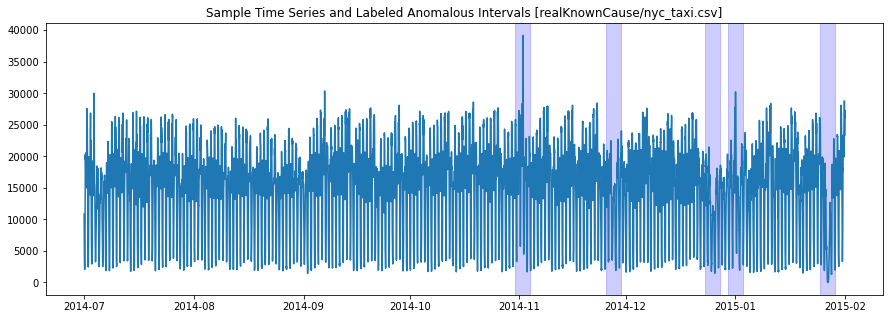

In [7]:
# plot a sample time series with its labeled anomalies

key = list(time_series.keys())[0]

plt.figure(figsize=(15, 5))
plt.plot(time_series[key])
for start, end in labeled_intervals[key]:
    plt.axvspan(start, end, alpha=0.2, color='blue')
plt.title(f'Sample Time Series and Labeled Anomalous Intervals [{key}]')
plt.show()

## Prepare Training Data

To prepare the training data for DeepAR, we resample the time series at the specified frequency, convert them into the [required JSON format](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar-inputoutput) following the [official guidelines](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar_best_practices), and upload the resulting files to S3.

In [8]:
# resample time series at the specified frequency

resampled_time_series = {}
for key, ts in time_series.items():
    resampled_time_series[key] = ts.resample(FREQ.replace('min', 'T')).sum()

In [9]:
# create input files of the required format for DeepAR training

train_json, test_json = '', ''

for ts in resampled_time_series.values():
    t0, l = ts.index[0], ts.shape[0]
    test_start_idx = int(l * TRAIN_RATIO)
    train_json += json.dumps({'start': str(t0), 'target': list(ts['value'][:test_start_idx])}) + '\n'
    for idx in range(test_start_idx + PREDICTION_LENGTH, l, PREDICTION_LENGTH_STEP):
        test_json += json.dumps({'start': str(t0), 'target': list(ts['value'][:idx])}) + '\n'

with open(TRAIN_DATA_FILE, "wb") as f:
    f.write(train_json.encode('utf-8'))

with open(TEST_DATA_FILE, "wb") as f:
    f.write(test_json.encode('utf-8'))

In [10]:
# upload files to S3

s3_client.upload_file(TRAIN_DATA_FILE, S3_BUCKET, f'data/train/{TRAIN_DATA_FILE}')
s3_client.upload_file(TEST_DATA_FILE, S3_BUCKET, f'data/test/{TEST_DATA_FILE}')

## Train a Prediction Model (DeepAR)

[DeepAR](https://arxiv.org/abs/1704.04110) is a recurrent neural network consisting of LSTM layers developed for time series forecasting. To train a DeepAR model, we instantiate and [configure](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html) a [SageMaker estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html), and feed to it the formatted training data.

Since the goal is to predict normal behaviors without overfitting to anomalies, it may be important to apply regularization, e.g. via dropouts.

In [11]:
# instantiate and configure a SageMaker DeepAR estimator

estimator = sagemaker.estimator.Estimator(
    deepar_image_uri,
    role, 
    instance_count=1, 
    instance_type='ml.c4.xlarge',
    output_path=f's3://{S3_BUCKET}/output',
    sagemaker_session=sagemaker_session
)

hyperparameters = {
    'time_freq': FREQ,
    'prediction_length': str(PREDICTION_LENGTH),
    'context_length': str(CONTEXT_LENGTH),
    'num_layers': str(NUM_LAYERS),
    'num_cells': str(NUM_CELLS),
    'likelihood': 'gaussian',
    'epochs': str(EPOCHS),
    'mini_batch_size': str(MINI_BATCH_SIZE),
    'learning_rate': str(LEARNING_RATE),
    'dropout_rate': str(DROPOUT_RATE),
    'early_stopping_patience': str(EARLY_STOPPING_PATIENCE),
}

estimator.set_hyperparameters(**hyperparameters)

In [12]:
# train the estimator

data_channels = {'train': f's3://{S3_BUCKET}/data/train/', 'test': f's3://{S3_BUCKET}/data/test/'}

estimator.fit(inputs=data_channels)

2021-05-07 10:36:52 Starting - Starting the training job...
2021-05-07 10:36:54 Starting - Launching requested ML instancesProfilerReport-1620383812: InProgress
......
2021-05-07 10:38:19 Starting - Preparing the instances for training.........
2021-05-07 10:39:48 Downloading - Downloading input data
2021-05-07 10:39:48 Training - Downloading the training image..Arguments: train
[05/07/2021 10:40:04 INFO 140486065915264] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', 'num_layers': '2', 'test_quantiles': '[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]'}
[05/07/2021 1

[05/07/2021 10:40:40 INFO 140486065915264] Epoch[3] Batch[0] avg_epoch_loss=10.040617
[05/07/2021 10:40:40 INFO 140486065915264] #quality_metric: host=algo-1, epoch=3, batch=0 train loss <loss>=10.040616989135742
[05/07/2021 10:40:44 INFO 140486065915264] Epoch[3] Batch[5] avg_epoch_loss=9.905702
[05/07/2021 10:40:44 INFO 140486065915264] #quality_metric: host=algo-1, epoch=3, batch=5 train loss <loss>=9.905702273050943
[05/07/2021 10:40:44 INFO 140486065915264] Epoch[3] Batch [5]#011Speed: 172.03 samples/sec#011loss=9.905702
[05/07/2021 10:40:48 INFO 140486065915264] Epoch[3] Batch[10] avg_epoch_loss=9.773892
[05/07/2021 10:40:48 INFO 140486065915264] #quality_metric: host=algo-1, epoch=3, batch=10 train loss <loss>=9.615719223022461
[05/07/2021 10:40:48 INFO 140486065915264] Epoch[3] Batch [10]#011Speed: 166.98 samples/sec#011loss=9.615719
[05/07/2021 10:40:48 INFO 140486065915264] processed a total of 1325 examples
#metrics {"StartTime": 1620384038.4188964, "EndTime": 1620384048.541

[05/07/2021 10:41:22 INFO 140486065915264] Epoch[7] Batch[0] avg_epoch_loss=8.861640
[05/07/2021 10:41:22 INFO 140486065915264] #quality_metric: host=algo-1, epoch=7, batch=0 train loss <loss>=8.861639976501465
[05/07/2021 10:41:25 INFO 140486065915264] Epoch[7] Batch[5] avg_epoch_loss=8.879842
[05/07/2021 10:41:25 INFO 140486065915264] #quality_metric: host=algo-1, epoch=7, batch=5 train loss <loss>=8.879841804504395
[05/07/2021 10:41:25 INFO 140486065915264] Epoch[7] Batch [5]#011Speed: 171.11 samples/sec#011loss=8.879842
[05/07/2021 10:41:28 INFO 140486065915264] processed a total of 1257 examples
#metrics {"StartTime": 1620384079.5290775, "EndTime": 1620384088.986175, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 9457.034349441528, "count": 1, "min": 9457.034349441528, "max": 9457.034349441528}}}

[05/07/2021 10:41:28 INFO 140486065915264] #throughput_metric: host=algo-1, train throughput=132.9151770294312 r

[05/07/2021 10:42:11 INFO 140486065915264] Epoch[12] Batch[0] avg_epoch_loss=8.559295
[05/07/2021 10:42:11 INFO 140486065915264] #quality_metric: host=algo-1, epoch=12, batch=0 train loss <loss>=8.559294700622559
[05/07/2021 10:42:15 INFO 140486065915264] Epoch[12] Batch[5] avg_epoch_loss=8.600247
[05/07/2021 10:42:15 INFO 140486065915264] #quality_metric: host=algo-1, epoch=12, batch=5 train loss <loss>=8.600247065226236
[05/07/2021 10:42:15 INFO 140486065915264] Epoch[12] Batch [5]#011Speed: 167.97 samples/sec#011loss=8.600247
[05/07/2021 10:42:17 INFO 140486065915264] processed a total of 1256 examples
#metrics {"StartTime": 1620384128.5414367, "EndTime": 1620384137.9966278, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 9455.118894577026, "count": 1, "min": 9455.118894577026, "max": 9455.118894577026}}}

[05/07/2021 10:42:17 INFO 140486065915264] #throughput_metric: host=algo-1, train throughput=132.836053670

[05/07/2021 10:43:04 INFO 140486065915264] Epoch[17] Batch[5] avg_epoch_loss=8.524009
[05/07/2021 10:43:04 INFO 140486065915264] #quality_metric: host=algo-1, epoch=17, batch=5 train loss <loss>=8.524009386698404
[05/07/2021 10:43:04 INFO 140486065915264] Epoch[17] Batch [5]#011Speed: 149.81 samples/sec#011loss=8.524009
[05/07/2021 10:43:07 INFO 140486065915264] processed a total of 1274 examples
#metrics {"StartTime": 1620384177.286292, "EndTime": 1620384187.650705, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 10364.331007003784, "count": 1, "min": 10364.331007003784, "max": 10364.331007003784}}}

[05/07/2021 10:43:07 INFO 140486065915264] #throughput_metric: host=algo-1, train throughput=122.91984933946442 records/second
[05/07/2021 10:43:07 INFO 140486065915264] #progress_metric: host=algo-1, completed 36.0 % of epochs
[05/07/2021 10:43:07 INFO 140486065915264] #quality_metric: host=algo-1, epoch=17, train l

[05/07/2021 10:43:50 INFO 140486065915264] Epoch[22] Batch[0] avg_epoch_loss=8.320197
[05/07/2021 10:43:50 INFO 140486065915264] #quality_metric: host=algo-1, epoch=22, batch=0 train loss <loss>=8.320197105407715
[05/07/2021 10:43:54 INFO 140486065915264] Epoch[22] Batch[5] avg_epoch_loss=8.313301
[05/07/2021 10:43:54 INFO 140486065915264] #quality_metric: host=algo-1, epoch=22, batch=5 train loss <loss>=8.31330140431722
[05/07/2021 10:43:54 INFO 140486065915264] Epoch[22] Batch [5]#011Speed: 171.43 samples/sec#011loss=8.313301
[05/07/2021 10:43:57 INFO 140486065915264] processed a total of 1242 examples
#metrics {"StartTime": 1620384227.8020256, "EndTime": 1620384237.1739662, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 9371.864080429077, "count": 1, "min": 9371.864080429077, "max": 9371.864080429077}}}

[05/07/2021 10:43:57 INFO 140486065915264] #throughput_metric: host=algo-1, train throughput=132.5222625013

[05/07/2021 10:44:47 INFO 140486065915264] Epoch[27] Batch[10] avg_epoch_loss=8.222493
[05/07/2021 10:44:47 INFO 140486065915264] #quality_metric: host=algo-1, epoch=27, batch=10 train loss <loss>=8.201795196533203
[05/07/2021 10:44:47 INFO 140486065915264] Epoch[27] Batch [10]#011Speed: 165.03 samples/sec#011loss=8.201795
[05/07/2021 10:44:47 INFO 140486065915264] processed a total of 1349 examples
#metrics {"StartTime": 1620384277.3654878, "EndTime": 1620384287.455233, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 10089.613437652588, "count": 1, "min": 10089.613437652588, "max": 10089.613437652588}}}

[05/07/2021 10:44:47 INFO 140486065915264] #throughput_metric: host=algo-1, train throughput=133.69918843327733 records/second
[05/07/2021 10:44:47 INFO 140486065915264] #progress_metric: host=algo-1, completed 56.0 % of epochs
[05/07/2021 10:44:47 INFO 140486065915264] #quality_metric: host=algo-1, epoch=27, tra

[05/07/2021 10:45:34 INFO 140486065915264] Epoch[32] Batch[5] avg_epoch_loss=8.106264
[05/07/2021 10:45:34 INFO 140486065915264] #quality_metric: host=algo-1, epoch=32, batch=5 train loss <loss>=8.106263637542725
[05/07/2021 10:45:34 INFO 140486065915264] Epoch[32] Batch [5]#011Speed: 166.79 samples/sec#011loss=8.106264
[05/07/2021 10:45:38 INFO 140486065915264] Epoch[32] Batch[10] avg_epoch_loss=8.064904
[05/07/2021 10:45:38 INFO 140486065915264] #quality_metric: host=algo-1, epoch=32, batch=10 train loss <loss>=8.01527271270752
[05/07/2021 10:45:38 INFO 140486065915264] Epoch[32] Batch [10]#011Speed: 166.68 samples/sec#011loss=8.015273
[05/07/2021 10:45:38 INFO 140486065915264] processed a total of 1317 examples
#metrics {"StartTime": 1620384328.4135792, "EndTime": 1620384338.6910105, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 10276.835203170776, "count": 1, "min": 10276.835203170776, "max": 10276.835203170

[05/07/2021 10:46:28 INFO 140486065915264] Epoch[37] Batch[10] avg_epoch_loss=8.052431
[05/07/2021 10:46:28 INFO 140486065915264] #quality_metric: host=algo-1, epoch=37, batch=10 train loss <loss>=8.014702606201173
[05/07/2021 10:46:28 INFO 140486065915264] Epoch[37] Batch [10]#011Speed: 170.50 samples/sec#011loss=8.014703
[05/07/2021 10:46:28 INFO 140486065915264] processed a total of 1285 examples
#metrics {"StartTime": 1620384378.0242941, "EndTime": 1620384388.1658576, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 10140.931606292725, "count": 1, "min": 10140.931606292725, "max": 10140.931606292725}}}

[05/07/2021 10:46:28 INFO 140486065915264] #throughput_metric: host=algo-1, train throughput=126.712438820597 records/second
[05/07/2021 10:46:28 INFO 140486065915264] #progress_metric: host=algo-1, completed 76.0 % of epochs
[05/07/2021 10:46:28 INFO 140486065915264] #quality_metric: host=algo-1, epoch=37, trai

[05/07/2021 10:47:17 INFO 140486065915264] processed a total of 1280 examples
#metrics {"StartTime": 1620384427.940414, "EndTime": 1620384437.3009498, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 9360.456705093384, "count": 1, "min": 9360.456705093384, "max": 9360.456705093384}}}

[05/07/2021 10:47:17 INFO 140486065915264] #throughput_metric: host=algo-1, train throughput=136.74340257566803 records/second
[05/07/2021 10:47:17 INFO 140486065915264] #progress_metric: host=algo-1, completed 86.0 % of epochs
[05/07/2021 10:47:17 INFO 140486065915264] #quality_metric: host=algo-1, epoch=42, train loss <loss>=8.026811361312866
[05/07/2021 10:47:17 INFO 140486065915264] loss did not improve
[05/07/2021 10:47:19 INFO 140486065915264] Epoch[43] Batch[0] avg_epoch_loss=8.017208
[05/07/2021 10:47:19 INFO 140486065915264] #quality_metric: host=algo-1, epoch=43, batch=0 train loss <loss>=8.017208099365234
[05/07/2021 10:47:

[05/07/2021 10:48:03 INFO 140486065915264] Epoch[47] Batch[5] avg_epoch_loss=8.008494
[05/07/2021 10:48:03 INFO 140486065915264] #quality_metric: host=algo-1, epoch=47, batch=5 train loss <loss>=8.008493661880493
[05/07/2021 10:48:03 INFO 140486065915264] Epoch[47] Batch [5]#011Speed: 163.72 samples/sec#011loss=8.008494
[05/07/2021 10:48:08 INFO 140486065915264] Epoch[47] Batch[10] avg_epoch_loss=7.980208
[05/07/2021 10:48:08 INFO 140486065915264] #quality_metric: host=algo-1, epoch=47, batch=10 train loss <loss>=7.9462662696838375
[05/07/2021 10:48:08 INFO 140486065915264] Epoch[47] Batch [10]#011Speed: 135.20 samples/sec#011loss=7.946266
[05/07/2021 10:48:08 INFO 140486065915264] processed a total of 1300 examples
#metrics {"StartTime": 1620384476.866692, "EndTime": 1620384488.1092315, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 11242.468118667603, "count": 1, "min": 11242.468118667603, "max": 11242.46811866


2021-05-07 10:49:22 Completed - Training job completed
ProfilerReport-1620383812: NoIssuesFound
Training seconds: 562
Billable seconds: 562


## Obtain Predicted Time Series

With a trained DeepAR model, we proceed to obtain time series predictions over a sequence of overlapping rolling windows, each based on the portion of the original time series preceding the window. To do so, we prepare input data in the [required JSON format](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html), perform model inference using [Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html#deepar-batch), and finally retrieve the output data.

DeepAR provides a probabilistic prediction at each future time stamp. For subsequent analysis, we specify the output to include 10th, 50th and 90th percentiles.

In [13]:
# create & upload input files of the required format for DeepAR inference

prediction_window_starts = {}

for group, files in TIME_SERIES_FILES.items():
    for file in files:
        key = f'{group}/{file}'
        ts = resampled_time_series[key]
        t0, l = ts.index[0], ts.shape[0]
        starts = np.arange(CONTEXT_LENGTH, l - PREDICTION_LENGTH + 1, PREDICTION_LENGTH_STEP)
        prediction_window_starts[key] = starts

        input_json = ''
        for idx in starts:
            input_json += json.dumps({'start': str(t0), 'target': list(ts['value'][:idx])}) + '\n'
        
        inf_file = 'inference_{}.json'.format(file.split('.')[0])
        with open(inf_file, 'wb') as f:
            f.write(input_json.encode('utf-8'))
        s3_client.upload_file(inf_file, S3_BUCKET, f'data/inference/{inf_file}')

In [14]:
# specify the output configuration

inference_config = {
    'num_samples': 1000,
    'output_types': ['quantiles'],
    'quantiles': ['0.1', '0.5', '0.9']
}

In [15]:
# apply Batch Transform for model inference

transformer = estimator.transformer(
    instance_count=1,
    instance_type='ml.c4.xlarge',
    strategy='SingleRecord',
    assemble_with='Line',
    output_path=f's3://{S3_BUCKET}/data/inference/',
    env={'DEEPAR_INFERENCE_CONFIG': json.dumps(inference_config)}
)

for group, files in TIME_SERIES_FILES.items():
    for file in files:
        inf_file = 'inference_{}.json'.format(file.split('.')[0])
        transformer.transform(f's3://{S3_BUCKET}/data/inference/{inf_file}', split_type='Line')

................................Arguments: serve
Failed to set debug level to 20, using INFO
[05/07/2021 10:54:49 INFO 139778220467584] Estimated memory required per model 66.62027835845947MB.
[05/07/2021 10:54:49 INFO 139778220467584] Estimated available memory 6518.091474533081MB.
[05/07/2021 10:54:49 INFO 139778220467584] Estimated maximum number of workers for the available memory is 97.
[05/07/2021 10:54:49 INFO 139778220467584] Using 4 workers
[05/07/2021 10:54:49 INFO 139778220467584] loading entry points
[05/07/2021 10:54:49 INFO 139778220467584] Prediction endpoint operating in batch mode
[05/07/2021 10:54:49 INFO 139778220467584] loaded request iterator application/jsonlines
[05/07/2021 10:54:49 INFO 139778220467584] loaded response encoder application/jsonlines
[05/07/2021 10:54:49 INFO 139778220467584] loaded model class model
Arguments: serve
Failed to set debug level to 20, using INFO
[05/07/2021 10:54:49 INFO 139778220467584] Estimated memory required per model 66.620278

[05/07/2021 10:55:02 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620384902.0583787, "EndTime": 1620384902.076198, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.027179718017578125, "count": 1, "min": 0.027179718017578125, "max": 0.027179718017578125}}}

[05/07/2021 10:55:02 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
[05/07/2021 10:55:02 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620384902.0583787, "EndTime": 1620384902.076198, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.027179718017578125, "count": 1, "min": 0.027179718017578125, "max": 0.027179718017578125}}}

[05/07/2021 10:55:02 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1

#metrics {"StartTime": 1620384913.760328, "EndTime": 1620384915.6892736, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.087738037109375, "count": 1, "min": 0.087738037109375, "max": 0.087738037109375}}}

#metrics {"StartTime": 1620384915.6893868, "EndTime": 1620384915.6896029, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

#metrics {"StartTime": 1620384913.7845132, "EndTime": 1620384915.7065349, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.07772445678710938, "count": 1, "min": 0.07772445678710938, "max": 0.07772445678710938}}}

#metrics {"StartTime": 1620384915.7066445, "EndTime": 1620384915.706882, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scorin

#metrics {"StartTime": 1620384919.632402, "EndTime": 1620384919.6656268, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.027894973754882812, "count": 1, "min": 0.027894973754882812, "max": 0.027894973754882812}}}

#metrics {"StartTime": 1620384919.632402, "EndTime": 1620384919.6656268, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.027894973754882812, "count": 1, "min": 0.027894973754882812, "max": 0.027894973754882812}}}

#metrics {"StartTime": 1620384919.6311285, "EndTime": 1620384921.55312, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.07581710815429688, "count": 1, "min": 0.07581710815429688, "max": 0.07581710815429688}}}

#metrics {"StartTime": 1620384921.5532284, "EndTime": 1620384921.5534697, "Dimensions": {"Algorithm":

[05/07/2021 10:55:31 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620384931.352874, "EndTime": 1620384931.388634, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.025272369384765625, "count": 1, "min": 0.025272369384765625, "max": 0.025272369384765625}}}

[05/07/2021 10:55:31 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620384931.3724928, "EndTime": 1620384931.4003844, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.029087066650390625, "count": 1, "min": 0.029087066650390625, "max": 0.029087066650390625}}}

[05/07/2021 10:55:31 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620384931.352874, "EndTime": 1620384931.388634, "Dimensions": {"Algorithm": "DeepARModel", "Hos

#metrics {"StartTime": 1620384943.0750434, "EndTime": 1620384943.0753026, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 10:55:43 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620384943.075357, "EndTime": 1620384943.1184883, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.027179718017578125, "count": 1, "min": 0.027179718017578125, "max": 0.027179718017578125}}}

#metrics {"StartTime": 1620384941.2158158, "EndTime": 1620384943.141252, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.13828277587890625, "count": 1, "min": 0.13828277587890625, "max": 0.13828277587890625}}}

#metrics {"StartTime": 1620384943.141359, "EndTime": 16203849

#metrics {"StartTime": 1620384953.0634396, "EndTime": 1620384953.0636966, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 10:55:53 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620384953.0637634, "EndTime": 1620384953.096103, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.028133392333984375, "count": 1, "min": 0.028133392333984375, "max": 0.028133392333984375}}}

#metrics {"StartTime": 1620384953.0634396, "EndTime": 1620384953.0636966, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 10:55:53 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 16203

#metrics {"StartTime": 1620384964.5063832, "EndTime": 1620384964.5066557, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 10:56:04 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620384964.5068064, "EndTime": 1620384964.551606, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.02574920654296875, "count": 1, "min": 0.02574920654296875, "max": 0.02574920654296875}}}

#metrics {"StartTime": 1620384962.7020066, "EndTime": 1620384964.6494365, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.08225440979003906, "count": 1, "min": 0.08225440979003906, "max": 0.08225440979003906}}}

#metrics {"StartTime": 1620384964.6495478, "EndTime": 162038496

#metrics {"StartTime": 1620384974.3393352, "EndTime": 1620384974.384477, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.028371810913085938, "count": 1, "min": 0.028371810913085938, "max": 0.028371810913085938}}}

#metrics {"StartTime": 1620384974.3393352, "EndTime": 1620384974.384477, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.028371810913085938, "count": 1, "min": 0.028371810913085938, "max": 0.028371810913085938}}}

[05/07/2021 10:56:14 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620384974.3409748, "EndTime": 1620384974.3868985, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.025033950805664062, "count": 1, "min": 0.025033950805664062, "max": 0.025033950805664062}}}

#metrics {

#metrics {"StartTime": 1620384984.2346017, "EndTime": 1620384984.2349148, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 10:56:24 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620384984.2354321, "EndTime": 1620384984.2813666, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.026464462280273438, "count": 1, "min": 0.026464462280273438, "max": 0.026464462280273438}}}

[05/07/2021 10:56:24 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620384984.2327008, "EndTime": 1620384984.2879715, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.028371810913085938, "count": 1, "min": 0.028371810913085938, "m

#metrics {"StartTime": 1620384992.3611782, "EndTime": 1620384994.2932298, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.08392333984375, "count": 1, "min": 0.08392333984375, "max": 0.08392333984375}}}

#metrics {"StartTime": 1620384994.2933362, "EndTime": 1620384994.293601, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 10:56:34 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620384994.2936575, "EndTime": 1620384994.3404787, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.0209808349609375, "count": 1, "min": 0.0209808349609375, "max": 0.0209808349609375}}}

#metrics {"StartTime": 1620384992.9366624, "EndTime": 1620384994.859569, "D

[05/07/2021 10:56:46 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385006.0274625, "EndTime": 1620385006.089316, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.026226043701171875, "count": 1, "min": 0.026226043701171875, "max": 0.026226043701171875}}}

#metrics {"StartTime": 1620385004.2171803, "EndTime": 1620385006.132249, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.07939338684082031, "count": 1, "min": 0.07939338684082031, "max": 0.07939338684082031}}}

#metrics {"StartTime": 1620385006.1323516, "EndTime": 1620385006.1326325, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 10:56:46 INFO 139778220467584] #memory_usage::<ba

#metrics {"StartTime": 1620385012.0634928, "EndTime": 1620385014.0029466, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.08654594421386719, "count": 1, "min": 0.08654594421386719, "max": 0.08654594421386719}}}

#metrics {"StartTime": 1620385014.0030565, "EndTime": 1620385014.0033662, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

#metrics {"StartTime": 1620385012.062804, "EndTime": 1620385014.0052173, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.08344650268554688, "count": 1, "min": 0.08344650268554688, "max": 0.08344650268554688}}}

#metrics {"StartTime": 1620385014.005317, "EndTime": 1620385014.0056062, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "

[05/07/2021 10:57:04 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385024.476799, "EndTime": 1620385024.5284176, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.026464462280273438, "count": 1, "min": 0.026464462280273438, "max": 0.026464462280273438}}}

[05/07/2021 10:57:04 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385024.476799, "EndTime": 1620385024.5284176, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.026464462280273438, "count": 1, "min": 0.026464462280273438, "max": 0.026464462280273438}}}

#metrics {"StartTime": 1620385024.02106, "EndTime": 1620385025.973612, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.09

#metrics {"StartTime": 1620385034.0716588, "EndTime": 1620385036.0063217, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.08392333984375, "count": 1, "min": 0.08392333984375, "max": 0.08392333984375}}}

#metrics {"StartTime": 1620385036.006429, "EndTime": 1620385036.006749, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

#metrics {"StartTime": 1620385034.0726082, "EndTime": 1620385036.008163, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.07605552673339844, "count": 1, "min": 0.07605552673339844, "max": 0.07605552673339844}}}

#metrics {"StartTime": 1620385036.008254, "EndTime": 1620385036.008544, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "

#metrics {"StartTime": 1620385046.2392948, "EndTime": 1620385046.2974982, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.023603439331054688, "count": 1, "min": 0.023603439331054688, "max": 0.023603439331054688}}}

#metrics {"StartTime": 1620385046.2392948, "EndTime": 1620385046.2974982, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.023603439331054688, "count": 1, "min": 0.023603439331054688, "max": 0.023603439331054688}}}

#metrics {"StartTime": 1620385046.0547154, "EndTime": 1620385047.9873314, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.08511543273925781, "count": 1, "min": 0.08511543273925781, "max": 0.08511543273925781}}}

#metrics {"StartTime": 1620385047.9874442, "EndTime": 1620385047.9877536, "Dimensions": {"Algorit

#metrics {"StartTime": 1620385056.161997, "EndTime": 1620385056.162305, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 10:57:36 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385056.1623611, "EndTime": 1620385056.2254632, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.027179718017578125, "count": 1, "min": 0.027179718017578125, "max": 0.027179718017578125}}}

[05/07/2021 10:57:36 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385056.1622427, "EndTime": 1620385056.231767, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.026226043701171875, "count": 1, "min": 0.026226043701171875, "max"

[05/07/2021 10:57:46 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385066.243351, "EndTime": 1620385066.3162384, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.024080276489257812, "count": 1, "min": 0.024080276489257812, "max": 0.024080276489257812}}}

[05/07/2021 10:57:46 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385066.2304022, "EndTime": 1620385066.3171117, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.025272369384765625, "count": 1, "min": 0.025272369384765625, "max": 0.025272369384765625}}}

[05/07/2021 10:57:46 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385066.243351, "EndTime": 1620385066.3162384, "Dimensions": {"Algorithm": "DeepARModel", "H

[05/07/2021 10:57:56 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385076.3220093, "EndTime": 1620385076.3994606, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.028371810913085938, "count": 1, "min": 0.028371810913085938, "max": 0.028371810913085938}}}

[05/07/2021 10:57:56 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385076.3184917, "EndTime": 1620385076.400064, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.026464462280273438, "count": 1, "min": 0.026464462280273438, "max": 0.026464462280273438}}}

[05/07/2021 10:57:56 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385076.3220093, "EndTime": 1620385076.3994606, "Dimensions": {"Algorithm": "DeepARModel", "

#metrics {"StartTime": 1620385084.5808358, "EndTime": 1620385086.543259, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.10180473327636719, "count": 1, "min": 0.10180473327636719, "max": 0.10180473327636719}}}

#metrics {"StartTime": 1620385086.5433621, "EndTime": 1620385086.5437074, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 10:58:06 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385086.5309987, "EndTime": 1620385086.616454, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.025987625122070312, "count": 1, "min": 0.025987625122070312, "max": 0.025987625122070312}}}

[05/07/2021 10:58:06 INFO 139778220467584] #memory_usage::<ba

#metrics {"StartTime": 1620385094.706954, "EndTime": 1620385096.6418269, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.08344650268554688, "count": 1, "min": 0.08344650268554688, "max": 0.08344650268554688}}}

#metrics {"StartTime": 1620385096.6419396, "EndTime": 1620385096.6422822, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

#metrics {"StartTime": 1620385094.7438774, "EndTime": 1620385096.679696, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.09274482727050781, "count": 1, "min": 0.09274482727050781, "max": 0.09274482727050781}}}

#metrics {"StartTime": 1620385094.706954, "EndTime": 1620385096.6418269, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "s

#metrics {"StartTime": 1620385104.7402267, "EndTime": 1620385104.7405505, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

#metrics {"StartTime": 1620385102.8414285, "EndTime": 1620385104.7957268, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.08678436279296875, "count": 1, "min": 0.08678436279296875, "max": 0.08678436279296875}}}

#metrics {"StartTime": 1620385104.7958329, "EndTime": 1620385104.7961297, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 10:58:24 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385104.7406085, "EndTime": 1620385104.8234127, "Dimensions": {"Algorithm": "DeepARModel",

#metrics {"StartTime": 1620385116.8466854, "EndTime": 1620385116.8470356, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

#metrics {"StartTime": 1620385116.8466854, "EndTime": 1620385116.8470356, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 10:58:36 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385116.8470945, "EndTime": 1620385116.9262676, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.021457672119140625, "count": 1, "min": 0.021457672119140625, "max": 0.021457672119140625}}}

#metrics {"StartTime": 1620385115.0488706, "EndTime": 1620385117.0039792, "Dimensions": {"Algorithm": "DeepARModel", "Host

#metrics {"StartTime": 1620385125.1505935, "EndTime": 1620385125.2377086, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.023365020751953125, "count": 1, "min": 0.023365020751953125, "max": 0.023365020751953125}}}

#metrics {"StartTime": 1620385123.6498396, "EndTime": 1620385125.564428, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.08940696716308594, "count": 1, "min": 0.08940696716308594, "max": 0.08940696716308594}}}

#metrics {"StartTime": 1620385125.5645475, "EndTime": 1620385125.5650706, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 10:58:45 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385125.1505935, "EndTime": 162038

#metrics {"StartTime": 1620385133.3876002, "EndTime": 1620385135.325834, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.08797645568847656, "count": 1, "min": 0.08797645568847656, "max": 0.08797645568847656}}}

#metrics {"StartTime": 1620385135.3259463, "EndTime": 1620385135.326306, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 10:58:55 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385135.3263671, "EndTime": 1620385135.4142776, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.025033950805664062, "count": 1, "min": 0.025033950805664062, "max": 0.025033950805664062}}}

#metrics {"StartTime": 1620385133.6457565, "EndTime": 1620385

#metrics {"StartTime": 1620385143.5260534, "EndTime": 1620385145.4709196, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.08320808410644531, "count": 1, "min": 0.08320808410644531, "max": 0.08320808410644531}}}

#metrics {"StartTime": 1620385145.471029, "EndTime": 1620385145.4714189, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 10:59:05 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385145.4714894, "EndTime": 1620385145.559125, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.024080276489257812, "count": 1, "min": 0.024080276489257812, "max": 0.024080276489257812}}}

#metrics {"StartTime": 1620385143.6610694, "EndTime": 1620385

#metrics {"StartTime": 1620385153.696872, "EndTime": 1620385155.619949, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.08106231689453125, "count": 1, "min": 0.08106231689453125, "max": 0.08106231689453125}}}

#metrics {"StartTime": 1620385155.620044, "EndTime": 1620385155.6204777, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

#metrics {"StartTime": 1620385153.7009435, "EndTime": 1620385155.6366034, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.08487701416015625, "count": 1, "min": 0.08487701416015625, "max": 0.08487701416015625}}}

#metrics {"StartTime": 1620385155.6367176, "EndTime": 1620385155.6371038, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "s

[05/07/2021 10:59:25 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385165.6815825, "EndTime": 1620385165.7786384, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.0247955322265625, "count": 1, "min": 0.0247955322265625, "max": 0.0247955322265625}}}

[05/07/2021 10:59:25 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385165.6804569, "EndTime": 1620385165.782088, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.026702880859375, "count": 1, "min": 0.026702880859375, "max": 0.026702880859375}}}

#metrics {"StartTime": 1620385163.880362, "EndTime": 1620385165.7991884, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.08726119995117

#metrics {"StartTime": 1620385173.9746745, "EndTime": 1620385175.9255302, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.05054473876953125, "count": 1, "min": 0.05054473876953125, "max": 0.05054473876953125}}}

#metrics {"StartTime": 1620385175.9256265, "EndTime": 1620385175.9259622, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 10:59:35 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385175.8830009, "EndTime": 1620385175.9840758, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.025987625122070312, "count": 1, "min": 0.025987625122070312, "max": 0.025987625122070312}}}

[05/07/2021 10:59:36 INFO 139778220467584] #memory_usage::<

[05/07/2021 10:59:46 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385186.2182097, "EndTime": 1620385186.326686, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.026941299438476562, "count": 1, "min": 0.026941299438476562, "max": 0.026941299438476562}}}

#metrics {"StartTime": 1620385184.5639288, "EndTime": 1620385186.4735608, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.08940696716308594, "count": 1, "min": 0.08940696716308594, "max": 0.08940696716308594}}}

#metrics {"StartTime": 1620385186.4740102, "EndTime": 1620385186.4744437, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 10:59:46 INFO 139778220467584] #memory_usage::<b

[05/07/2021 10:59:56 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385196.379526, "EndTime": 1620385196.4900458, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.025033950805664062, "count": 1, "min": 0.025033950805664062, "max": 0.025033950805664062}}}

[05/07/2021 10:59:56 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385196.4572456, "EndTime": 1620385196.5659614, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.0247955322265625, "count": 1, "min": 0.0247955322265625, "max": 0.0247955322265625}}}

#metrics {"StartTime": 1620385194.654744, "EndTime": 1620385196.5687745, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.08821

#metrics {"StartTime": 1620385208.668406, "EndTime": 1620385208.6688282, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 11:00:08 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385208.6167004, "EndTime": 1620385208.7385964, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.02765655517578125, "count": 1, "min": 0.02765655517578125, "max": 0.02765655517578125}}}

[05/07/2021 11:00:08 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385208.6689043, "EndTime": 1620385208.7861352, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.025987625122070312, "count": 1, "min": 0.025987625122070312, "max":

[05/07/2021 11:00:21 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385220.998609, "EndTime": 1620385221.1253512, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.20575523376464844, "count": 1, "min": 0.20575523376464844, "max": 0.20575523376464844}}}

[05/07/2021 11:00:21 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385220.9979045, "EndTime": 1620385221.1272101, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.05793571472167969, "count": 1, "min": 0.05793571472167969, "max": 0.05793571472167969}}}

[05/07/2021 11:00:21 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385220.998609, "EndTime": 1620385221.1253512, "Dimensions": {"Algorithm": "DeepARModel", "Host": 

#metrics {"StartTime": 1620385227.4550772, "EndTime": 1620385229.378017, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.08797645568847656, "count": 1, "min": 0.08797645568847656, "max": 0.08797645568847656}}}

#metrics {"StartTime": 1620385229.378128, "EndTime": 1620385229.378555, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 11:00:29 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385229.255466, "EndTime": 1620385229.3940241, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.03719329833984375, "count": 1, "min": 0.03719329833984375, "max": 0.03719329833984375}}}

[05/07/2021 11:00:29 INFO 139778220467584] #memory_usage::<batchbu

#metrics {"StartTime": 1620385237.6671243, "EndTime": 1620385239.5950367, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.08559226989746094, "count": 1, "min": 0.08559226989746094, "max": 0.08559226989746094}}}

#metrics {"StartTime": 1620385239.5951374, "EndTime": 1620385239.5956407, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 11:00:39 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385239.5686567, "EndTime": 1620385239.6951325, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.02384185791015625, "count": 1, "min": 0.02384185791015625, "max": 0.02384185791015625}}}

[05/07/2021 11:00:39 INFO 139778220467584] #memory_usage::<bat

#metrics {"StartTime": 1620385251.9463692, "EndTime": 1620385251.94681, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 11:00:52 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385251.9145534, "EndTime": 1620385252.0385752, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.024557113647460938, "count": 1, "min": 0.024557113647460938, "max": 0.024557113647460938}}}

[05/07/2021 11:00:52 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385251.9463692, "EndTime": 1620385251.94681, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 11:00:52 INFO 13977

#metrics {"StartTime": 1620385262.3692622, "EndTime": 1620385262.5841107, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.027179718017578125, "count": 1, "min": 0.027179718017578125, "max": 0.027179718017578125}}}

[05/07/2021 11:01:02 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385262.3844233, "EndTime": 1620385262.597858, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.025510787963867188, "count": 1, "min": 0.025510787963867188, "max": 0.025510787963867188}}}

[05/07/2021 11:01:02 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385262.3542264, "EndTime": 1620385262.6528616, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.0281333

#metrics {"StartTime": 1620385268.7801893, "EndTime": 1620385268.780658, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"invocations.count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}}}

[05/07/2021 11:01:08 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385268.699431, "EndTime": 1620385268.8331633, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.028371810913085938, "count": 1, "min": 0.028371810913085938, "max": 0.028371810913085938}}}

[05/07/2021 11:01:08 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385268.780736, "EndTime": 1620385268.9306645, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.028133392333984375, "count": 1, "min": 0.028133392333984375, "max"

[05/07/2021 11:01:17 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385277.4568574, "EndTime": 1620385277.5861194, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.026464462280273438, "count": 1, "min": 0.026464462280273438, "max": 0.026464462280273438}}}

[05/07/2021 11:01:17 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385277.5729208, "EndTime": 1620385277.7040327, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.02765655517578125, "count": 1, "min": 0.02765655517578125, "max": 0.02765655517578125}}}

[05/07/2021 11:01:17 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385277.4568574, "EndTime": 1620385277.5861194, "Dimensions": {"Algorithm": "DeepARModel", "Ho

[05/07/2021 11:01:27 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385287.3474061, "EndTime": 1620385287.4863214, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.025510787963867188, "count": 1, "min": 0.025510787963867188, "max": 0.025510787963867188}}}

[05/07/2021 11:01:27 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385287.4401436, "EndTime": 1620385287.577993, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.0286102294921875, "count": 1, "min": 0.0286102294921875, "max": 0.0286102294921875}}}

#metrics {"StartTime": 1620385285.7963827, "EndTime": 1620385287.7207317, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.0824

[05/07/2021 11:01:38 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385298.2180712, "EndTime": 1620385298.3501253, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.0247955322265625, "count": 1, "min": 0.0247955322265625, "max": 0.0247955322265625}}}

[05/07/2021 11:01:38 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385298.2180712, "EndTime": 1620385298.3501253, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.0247955322265625, "count": 1, "min": 0.0247955322265625, "max": 0.0247955322265625}}}

#metrics {"StartTime": 1620385297.9819262, "EndTime": 1620385299.910416, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum": 0.0929832458

[05/07/2021 11:01:48 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385308.4225278, "EndTime": 1620385308.5653014, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.025510787963867188, "count": 1, "min": 0.025510787963867188, "max": 0.025510787963867188}}}

[05/07/2021 11:01:48 INFO 139778220467584] #memory_usage::<batchbuffer> = 2.066802978515625 mb
#metrics {"StartTime": 1620385308.4225278, "EndTime": 1620385308.5653014, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"model.evaluate.time": {"sum": 0.025510787963867188, "count": 1, "min": 0.025510787963867188, "max": 0.025510787963867188}}}

#metrics {"StartTime": 1620385308.4773715, "EndTime": 1620385310.4099638, "Dimensions": {"Algorithm": "DeepARModel", "Host": "UNKNOWN", "Operation": "scoring"}, "Metrics": {"serve.jsonlines_encoder.time": {"sum":

In [16]:
# download & import inference outputs

predicted_10pctls, predicted_medians, predicted_90pctls = {}, {}, {}

for group, files in TIME_SERIES_FILES.items():
    for file in files:
        key = f'{group}/{file}'
        inf_file = 'inference_{}.json'.format(file.split('.')[0])
        s3_client.download_file(S3_BUCKET, f'data/inference/{inf_file}.out', f'{inf_file}.out')
        
        pctls_10, medians, pctls_90 = [], [], []
        with open(f'{inf_file}.out', 'r') as f:
            for l in f.readlines():
                qtls = json.loads(l)['quantiles']
                pctls_10.append(qtls['0.1'])
                medians.append(qtls['0.5'])
                pctls_90.append(qtls['0.9'])
        predicted_10pctls[key] = np.array(pctls_10)
        predicted_medians[key] = np.array(medians)
        predicted_90pctls[key] = np.array(pctls_90)

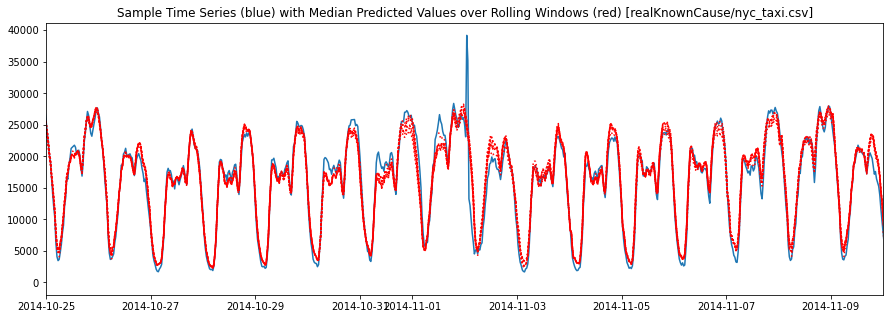

In [17]:
# plot a sample time series and corresponding predicted median values over rolling windows

key = list(time_series.keys())[0]

start_date = datetime.datetime.strptime('2014-10-25', '%Y-%m-%d')
end_date = datetime.datetime.strptime('2014-11-10', '%Y-%m-%d')

plt.figure(figsize=(15, 5))
plt.plot(resampled_time_series[key])
for idx, medians in zip(prediction_window_starts[key], predicted_medians[key]):
    times = resampled_time_series[key].index[idx : idx + PREDICTION_LENGTH] 
    plt.plot(times, medians, 'r:')
plt.title(f'Sample Time Series (blue) with Median Predicted Values over Rolling Windows (red) [{key}]')
plt.xlim(start_date, end_date)
plt.show()

## Identify Anomalous Intervals

First we measure the normality of each time series value by its median z-score with respect to associated probabilistic predictions. Then we identify anomalies as the time stamps at which the score exceeds a chosen threshold (together with some padding). The result is given as a sequence of disjoint intervals.

In [18]:
# (1) per window: estimate z-score of each actual value with respect to the predicted distribution
# (2) per time stamp: take median score across all overlapping windows

scores = {}

for key, ts in resampled_time_series.items():

    # (1)
    per_window_scores = []
    for i, s in enumerate(prediction_window_starts[key]):
        actual_values = np.array(ts['value'][s : s + PREDICTION_LENGTH])
        zs = (actual_values - predicted_medians[key][i]) / (predicted_90pctls[key][i] - predicted_10pctls[key][i]) * norm.ppf(0.9) * 2
        per_window_scores.append(zs)
    per_window_scores = np.stack(per_window_scores, axis=0)
    
    # (2)
    agg_scores = np.full((ts.shape[0], PREDICTION_LENGTH), np.nan)
    for i in range(PREDICTION_LENGTH):
        agg_scores[prediction_window_starts[key] + i, i] = per_window_scores[:, i]
    agg_scores = np.nanmedian(agg_scores, axis=1)
    
    scores[key] = agg_scores
    del per_window_scores, agg_scores

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [19]:
# identify anomalous intervals by:
# (1) finding the time stamps where absolute score exceeds a threshold
# (2) including any other time stamps within a certain distance

def get_anomalous_intervals(scores, threshold, padding):

    flags = (np.absolute(scores) > threshold)
    starts = np.argwhere(flags & np.insert(~flags[:-1], 0, True)).flatten()
    ends = np.argwhere(flags & np.append(~flags[1:], True)).flatten()
    intervals = np.stack((starts, ends), axis=1)

    padded_intervals = []
    for start, end in intervals:
        p_start, p_end = max(start - padding, 0), min(end + padding, len(scores) - 1)
        if (len(padded_intervals) > 0) and (p_start <= padded_intervals[-1][1]):
            padded_intervals[-1][1] = p_end
        else:
            padded_intervals.append([p_start, p_end])
    padded_intervals = np.array(padded_intervals)
    
    return padded_intervals


detected_intervals = {}
for key, ts in resampled_time_series.items():
    intervals = get_anomalous_intervals(scores[key], SCORE_THRESHOLD, PADDING)
    detected_intervals[key] = [[ts.index[t].to_pydatetime() for t in interval] for interval in intervals]    

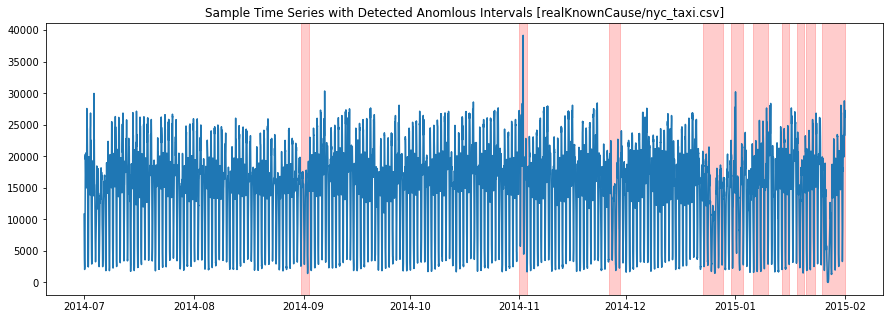

In [20]:
# plot a sample time series with the detected anomalous intervals

key = list(time_series.keys())[0]

plt.figure(figsize=(15, 5))
plt.plot(resampled_time_series[key])
for start, end in detected_intervals[key]:
    plt.axvspan(start, end, alpha=0.2, color='red')
plt.title(f'Sample Time Series with Detected Anomlous Intervals [{key}]')
plt.show()

## Evaluate Detected Anomalies

When hand-labeled anomalies are available, we may evaluate the detected anomalies via various metrics. Suppose the role of our detector is to flag issues for further inspection by experts. In this case, it would be desirable to capture as many of the actual anomalies as possible (**high recall**), but without raising too many false alarms (**acceptable precision**). For this reason the metrics we consider are mainly recall and F1-score.

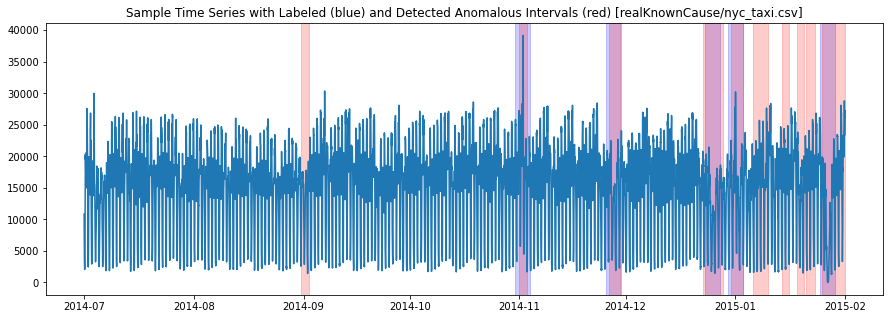

In [21]:
# plot a sample time series with both labeled and detected anomalous intervals

key = list(time_series.keys())[0]

plt.figure(figsize=(15, 5))
plt.plot(resampled_time_series[key])
for start, end in labeled_intervals[key]:
    plt.axvspan(start, end, alpha=0.2, color='blue')
for start, end in detected_intervals[key]:
    plt.axvspan(start, end, alpha=0.2, color='red')
plt.title(f'Sample Time Series with Labeled (blue) and Detected Anomalous Intervals (red) [{key}]')
plt.show()

In [22]:
# calculate recall and F1 score

def get_evaluation_metrics(labeled_intervals, detected_intervals):

    l_labeled = sum([(e - s).total_seconds() for s, e in labeled_intervals])
    l_detected = sum([(e - s).total_seconds() for s, e in detected_intervals])

    l_overlap = 0
    for int1 in labeled_intervals:
        for int2 in detected_intervals:
            s = max(int1[0], int2[0])
            e = min(int1[1], int2[1])
            if s < e:
                l_overlap += (e - s).total_seconds()
                
    recall = l_overlap / l_labeled
    precision = l_overlap / l_detected
    f1 = 2 * recall * precision / (recall + precision)
    
    return recall, precision, f1


for key in time_series:
    print(f'{key} : ', end='')
    recall, _, f1 = get_evaluation_metrics(labeled_intervals[key], detected_intervals[key])
    print(f'recall = {recall:.3}, ', end='')
    print(f'F1 score = {f1:.3}', end='')
    print('')

realKnownCause/nyc_taxi.csv : recall = 0.768, F1 score = 0.599


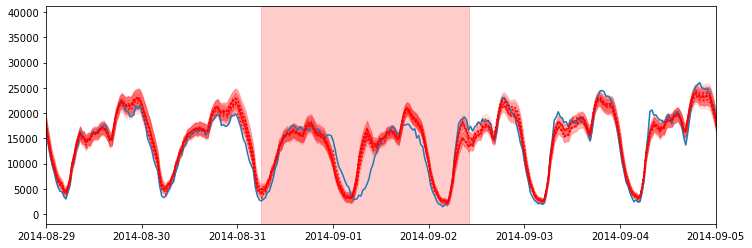

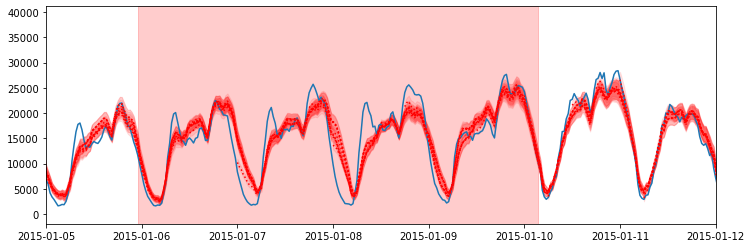

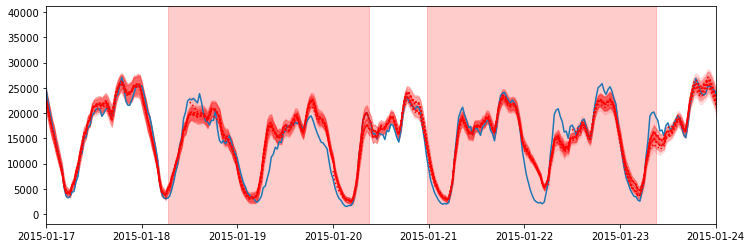

In [23]:
# examine discrepancies between labeled and detected intervals

def plot_results(start_date, end_date, time_series, labeled_intervals, detected_intervals,
                 prediction_window_starts, predicted_medians, predicted_10pctls, predicted_90pctls):

    start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')

    plt.figure(figsize=(12, 4))
    plt.plot(time_series)
    for start, end in labeled_intervals:
        if (start <= end_date) and (end >= start_date):
            plt.axvspan(start, end, alpha=0.2, color='blue')
    for idx, medians, pctls_10, pctls_90 in zip(prediction_window_starts, predicted_medians, predicted_10pctls, predicted_90pctls):
        if (time_series.index[idx] <= end_date) and (time_series.index[idx + PREDICTION_LENGTH] >= start_date):
            times = time_series.index[idx : idx + PREDICTION_LENGTH] 
            plt.plot(times, medians, 'r:')
            plt.fill_between(times, pctls_10, pctls_90, alpha=0.1, color='red')
    for start, end in detected_intervals:
        if (start <= end_date) and (end >= start_date):
            plt.axvspan(start, end, alpha=0.2, color='red')
    plt.xlim(start_date, end_date)
    plt.show()
    

key = list(time_series.keys())[0]
windows = [('2014-08-29', '2014-09-05'),
           ('2015-01-05', '2015-01-12'),
           ('2015-01-17', '2015-01-24')]

for start_date, end_date in windows:
    plot_results(start_date, end_date, resampled_time_series[key], labeled_intervals[key], detected_intervals[key],
                 prediction_window_starts[key], predicted_medians[key], predicted_10pctls[key], predicted_90pctls[key])


## Cleanup

In [24]:
# delete local files

for group, files in TIME_SERIES_FILES.items():
    for file in files:
        os.remove(f'{group}/{file}')
    os.rmdir(group)

files_to_delete = [LABELED_INTERVALS_FILE, TRAIN_DATA_FILE, TEST_DATA_FILE]
files_to_delete += [f for f in os.listdir('.') if f.startswith('inference_')]
for file in files_to_delete:
    os.remove(file)


In [25]:
# delete files in S3

folders_to_delete = ['output/', 'data/train/', 'data/test/', 'data/inference/']
for folder in folders_to_delete:
    boto3.resource('s3').Bucket(S3_BUCKET).objects.filter(Prefix=folder).delete()

## Extra: Sensitivity to Hyperparameters

Finally, we briefly examine to what extent the performance of our detector is sensitive to various hyperparameters. Each plot below shows how recall and F1-score vary with one hyperparameter as well as the score threshold. 

![](tuning.png) 